## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import json
from pandas.io.json import json_normalize
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

### Importing Dataset

In [2]:
final_df = pd.read_csv('cleaned_data.csv', index_col = 'created_at', parse_dates = True)

In [3]:
final_df.head()

,Unnamed: 0,entry_id,CO,CO2,NH4,Toluene,Alcohol,Humidity,Noise,Temperature
created_at,,,,,,,,,,
2023-02-15 06:34:40+00:00,0,1,4.76938,3.26710,4.87753,0.64884,1.54507,29.0,27.87349,26.4
2023-02-15 06:34:56+00:00,1,2,5.08085,3.42086,5.07526,0.68577,1.62607,29.0,27.71829,26.5
2023-02-15 06:35:13+00:00,2,3,5.36931,3.56097,5.25439,0.71972,1.70024,29.0,27.78416,26.5
2023-02-15 06:35:29+00:00,3,4,5.45458,3.60199,5.30665,0.72971,1.72201,29.0,27.97206,26.5
2023-02-15 06:35:45+00:00,4,5,5.99422,3.85769,5.63062,0.79251,1.85836,29.0,27.88033,26.4


<AxesSubplot:xlabel='created_at'>

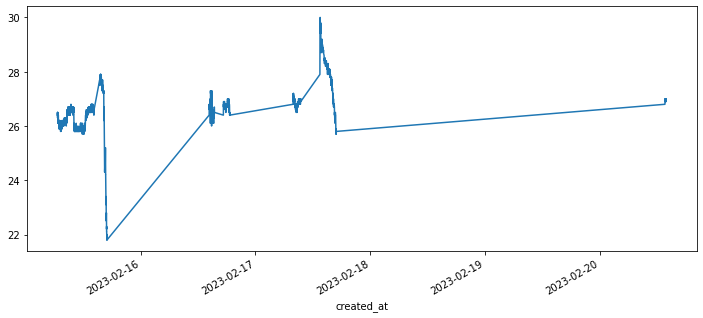

In [4]:
final_df['Temperature'].plot(figsize=(12,5))

### Augmented Dickey Fuller Test

In [5]:
from pandas.tseries.offsets import DateOffset
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

In [6]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ", dftest[0])
    print("2. p-value : ", dftest[1])
    print("3. No. of lags : ", dftest[2])
    print("4. Num of observations used for ADF regression and critical values calculation : ", dftest[3])
    print("5. Critical : ")
    for key, val in dftest[4].items():
        print("\t", key, ":", val)
    

In [7]:
ad_test(final_df['Temperature'])

1. ADF :  -3.7992037654648794
2. p-value :  0.0029154720277323504
3. No. of lags :  4
4. Num of observations used for ADF regression and critical values calculation :  3101
5. Critical : 
	 1% : -3.4324605196236315
	 5% : -2.8624724958174195
	 10% : -2.5672663901440913


### Applying Auto ARIMA Function

In [8]:
from pmdarima import auto_arima
#ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
stepwise_fit = auto_arima(final_df['Temperature'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3871.461, Time=10.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3836.578, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3873.869, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3873.239, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3838.571, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3871.869, Time=0.86 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3871.869, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3869.872, Time=1.73 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-3875.861, Time=0.81 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-3873.861, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3873.861, Time=0.77 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-3875.231, Time=0.39 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-3871.864, Time=0.67 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 19.886 seconds


In [10]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3106
Model:               SARIMAX(1, 1, 0)   Log Likelihood                1939.930
Date:                Mon, 20 Feb 2023   AIC                          -3875.861
Time:                        19:33:20   BIC                          -3863.779
Sample:                             0   HQIC                         -3871.523
                               - 3106                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1122      0.005    -20.468      0.000      -0.123      -0.101
sigma2         0.0168   2.72e-05    616.507      0.000       0.017       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          34057355.29
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                            14.57
Prob(H) (two-sided):                  0.00   Kurtosis:                       515.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Splitting the dataset into train and test

In [11]:
print(final_df.shape)

(3106, 10)


In [12]:
train=final_df.iloc[:-30]
test=final_df.iloc[-30:]

In [13]:
print(train.shape, test.shape)

(3076, 10) (30, 10)


### Fitting the model

In [14]:
model = ARIMA(train['Temperature'], order=(1,1,0))
model=model.fit()
model.summary()

<IPython.core.display.Javascript object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Temperature   No. Observations:                 3075
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1908.087
Method:                       css-mle   S.D. of innovations              0.130
Date:                Mon, 20 Feb 2023   AIC                          -3810.175
Time:                        19:33:35   BIC                          -3792.081
Sample:                             1   HQIC                         -3803.675
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0002      0.002      0.075      0.940      -0.004       0.004
ar.L1.D.Temperature    -0.1115      0.018     -6.223      0.000      -0.147      -0.076
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -8.9680           +0.0000j            8.9680            0.5000
-----------------------------------------------------------------------------
"""

### Making predictions on test

In [15]:
start = len(train)
end = len(train) + len(test)-1
pred=model.predict(start = start, end = end, typ='levels')
#print(pred)
pred.index = final_df.index[start:end+1]
print(pred)

created_at
2023-02-20 13:45:04+00:00    26.900177
2023-02-20 13:45:20+00:00    26.900334
2023-02-20 13:45:37+00:00    26.900494
2023-02-20 13:45:53+00:00    26.900653
2023-02-20 13:46:10+00:00    26.900813
2023-02-20 13:46:26+00:00    26.900972
2023-02-20 13:46:41+00:00    26.901131
2023-02-20 13:46:58+00:00    26.901291
2023-02-20 13:47:14+00:00    26.901450
2023-02-20 13:47:31+00:00    26.901609
2023-02-20 13:47:48+00:00    26.901769
2023-02-20 13:48:03+00:00    26.901928
2023-02-20 13:48:19+00:00    26.902087
2023-02-20 13:48:35+00:00    26.902247
2023-02-20 13:48:52+00:00    26.902406
2023-02-20 13:49:08+00:00    26.902566
2023-02-20 13:49:25+00:00    26.902725
2023-02-20 13:49:41+00:00    26.902884
2023-02-20 13:49:57+00:00    26.903044
2023-02-20 13:50:15+00:00    26.903203
2023-02-20 13:50:31+00:00    26.903362
2023-02-20 13:50:48+00:00    26.903522
2023-02-20 13:51:04+00:00    26.903681
2023-02-20 13:51:20+00:00    26.903840
2023-02-20 13:51:36+00:00    26.904000
2023-02-20 13:

In [22]:
test['Temperature'].mean()

26.969999999999995

In [23]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(pred, test['Temperature']))
print(rmse)

0.08137781515844943


In [24]:
model2 = ARIMA(final_df['Temperature'], order=(1,1,0))

<IPython.core.display.Javascript object>

In [25]:
model2=model2.fit()

In [26]:
final_df.tail()

,Unnamed: 0,entry_id,CO,CO2,NH4,Toluene,Alcohol,Humidity,Noise,Temperature
created_at,,,,,,,,,,
2023-02-20 13:51:51+00:00,3179,3180,3.89800,2.82141,4.29697,0.54384,1.31272,34.0,28.06618,26.9
2023-02-20 13:52:08+00:00,3180,3181,4.11463,2.93456,4.44546,0.57019,1.37135,34.0,28.03604,26.9
2023-02-20 13:52:24+00:00,3181,3182,3.83819,2.78988,4.25543,0.53653,1.29643,35.0,28.05615,27.0
2023-02-20 13:52:40+00:00,3182,3183,3.98943,2.86937,4.36000,0.55498,1.33754,35.0,28.09955,26.9
2023-02-20 13:52:56+00:00,3183,3184,3.98943,2.86937,4.36000,0.55498,1.33754,34.0,28.08956,27.0


<AxesSubplot:>

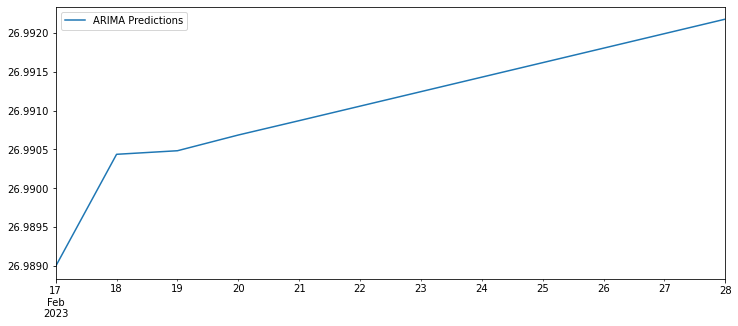

In [27]:
index_future_dates = pd.date_range(start='2023-02-17', end = '2023-02-28')
pred = model2.predict(start=len(final_df), end=len(final_df)+11, typ='levels').rename('ARIMA Predictions')
pred.index = index_future_dates
pred.plot(figsize=(12,5), legend=True)